# Miniminiai Tutorial 2: Customization via Callbacks

In this tutorial I'll show a few ways you can customize minai to suit your needs. We'll work with the same dataset as in tutorial 1 , but we'll train a variational autoencoder model to show how to modify the training process when dealing with a more complicated task.

In [ ]:
# Install requirements
!pip install -q minai datasets

In [ ]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import minai as mi # So we can see what is from minai in this tutorial
import torchvision.transforms.functional as TF
from functools import partial
from datasets import load_dataset

In [ ]:
# Set default matplotlib colormap to 'gray'
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'gray'

# The Data

We'll use MNIST as in Tutorial 1 since this is just for demonstration. I'm keeping the dataloader code identical, even though we don't use the class label in this tutorial.

In [ ]:
# Load a dataset from HF
dataset = load_dataset('mnist')

# Specify transforms
def transforms(b):
    b['image'] = [TF.to_tensor(o) for o in b['image']]
    return b
dataset = dataset.with_transform(transforms)

# Turn it into dls
dls = mi.DataLoaders.from_dd(dataset,batch_size=64)

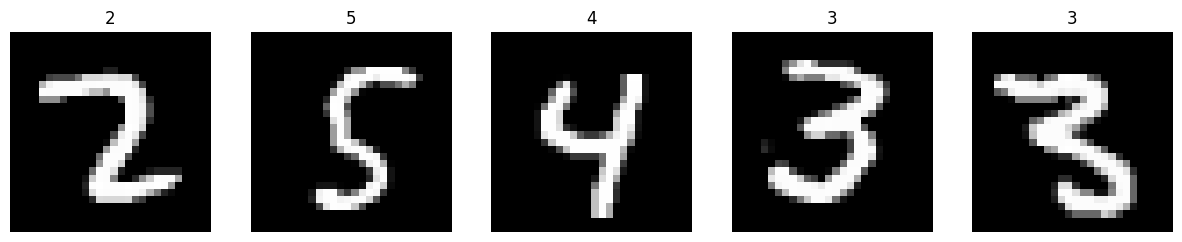

In [ ]:
# Look at the data
xb, yb = next(iter(dls.train))
mi.show_images(xb[:5], ncols=5, titles=list(yb[:5].numpy()))

# The Model

The model is a variational auto-encoder (VAE). It takes in an image, and compresses it down to a much smaller representation, 'z'. Unlike a normal autoencoder, the representation is not a single vector, but a pair of vectors, the mean and standard deviation of a normal distribution. The model then samples from this distribution to generate a new image. This is not a tutorial on VAEs, but if you want more info see [this video](https://www.youtube.com/watch?v=9zKuYvjFFS8). 

In [ ]:
class ConvVAE(nn.Module):
    def __init__(self, hdim=20):
        super(ConvVAE, self).__init__()
        # Encoder layers
        self.enc_conv1 = nn.Conv2d(1, 32, 3)
        self.enc_conv2 = nn.Conv2d(32, 32, 3)
        self.enc_fc1 = nn.Linear(32*24*24, 128)
        self.enc_fc2_mean = nn.Linear(128, hdim)
        self.enc_fc2_logvar = nn.Linear(128, hdim)

        # Decoder layers
        self.dec_fc1 = nn.Linear(hdim, 128)
        self.dec_fc2 = nn.Linear(128, 32*24*24)
        self.dec_unflatten = nn.Unflatten(dim=-1, unflattened_size=(32, 24, 24))
        self.dec_conv1 = nn.ConvTranspose2d(32, 32, 3)
        self.dec_conv2 = nn.ConvTranspose2d(32, 1, 3)

    def encode(self, x):
        x = self.enc_conv1(x)
        x = F.relu(x)
        x = self.enc_conv2(x)
        x = F.relu(x)
        x = torch.flatten(x, 1)
        x = self.enc_fc1(x)
        x = F.relu(x)
        mean = self.enc_fc2_mean(x)
        logvar = self.enc_fc2_logvar(x)
        return mean, logvar
    
    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5*logvar) # 0.5*logvar in the exponent is being fancy. Can do std = torch.sqrt(torch.exp(logvar))
        eps = torch.randn_like(std) # This isn't dependant on mean or logvar
        return mean + eps*std # So we can trace gradients back through this operation

    def decode(self, x):
        x = self.dec_fc1(x)
        x = F.relu(x)
        x = self.dec_fc2(x)
        x = F.relu(x)
        x = self.dec_unflatten(x)
        x = self.dec_conv1(x)
        x = F.relu(x)
        x = self.dec_conv2(x)
        return torch.sigmoid(x) # Clamps value between 0 and 1

    def forward(self, x, return_dist = False):
        mean, logvar = self.encode(x) # Predict a distribution
        z = self.reparameterize(mean, logvar) # Sample from it
        if return_dist: return self.decode(z), mean, logvar 
        return self.decode(z)

In [ ]:
model = ConvVAE()

The forward method takes an input image, encodes it, samples 'z' from the distribution and decodes that back to an image again. However, for training we need to access the mean and standard deviation of the distribution, so I've added the `return_dist` argument to `forward` that returns the mean and standard deviation as well as the output image:

In [ ]:
reconstruction, mean, logvar = model(xb, return_dist=True)

reconstruction.shape, mean.shape, logvar.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64, 20]), torch.Size([64, 20]))

# Custom Training Callback

Here's the source code for the normal TrainCB:

```python
class TrainCB(Callback):
    def __init__(self, n_inp=1): self.n_inp = n_inp
    def predict(self, learn): learn.preds = learn.model(*learn.batch[:self.n_inp])
    def get_loss(self, learn): learn.loss = learn.loss_func(learn.preds, *learn.batch[self.n_inp:])
    def backward(self, learn): learn.loss.backward()
    def step(self, learn): learn.opt.step()
    def zero_grad(self, learn): learn.opt.zero_grad()
```

This assumes that the batch is a tuple of inputs and targets, which is the case for the data we have if we're doing classification. For our VAE, however, we don't care about the class label at all, and our input (batch[0]) is also our target! We also need a custom loss function operating on multiple different outputs returned by the model. So, it makes sense to write our own `predict` and `get_loss` functions, which we can do by subclassing the TrainCB and overriding the relevant methods:


In [ ]:
class VaeTrainCB(mi.TrainCB):
    
    def predict(self, learn): 
        # learn.preds stores the model outputs - in this case (reconstruction, mean, logvar)
        learn.preds = learn.model(learn.batch[0], return_dist=True) 
    
    def get_loss(self, learn):
        # Get the predictions
        reconstruction, mean, logvar = learn.preds

        # Reconstruction loss
        BCE = F.binary_cross_entropy(reconstruction, learn.batch[0], reduction='sum') # Compare reconstruction with original image
        
        # KL Divergence
        KLD = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
        
        # Combine the two to get final loss
        learn.loss = BCE + KLD

Again, not a VAE tutorial but as you can see we have two terms in our loss function. One measures how well the model has reconstructed the image from 'z', the other (KL Divergence) is there to force the VAE to learn a distribution that is close to a standard normal distribution. This is a regularizer that helps the model to learn meaningful representations, so that (if all goes well) we can later use it to generate new images.

As an alternative to this callback approach, you could create a new learner class inheriting from TrainLearner and define the `predict` and `get_loss` functions there instead. With a bit of effort you could also tweak the model, loss function and dataloaders so that no modifications to the TrainLearner are needed at all (but that would defeat the point of this tutorial!).

Apart from the use of our new custom callback, the training loop is identical to the one in tutorial 1:

loss,epoch,train
9514.281,0,train
15378.260,0,eval


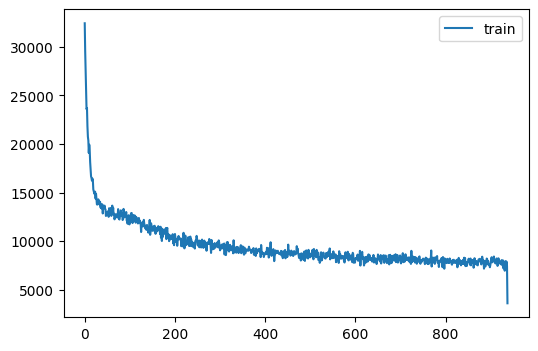

In [ ]:
# Specify the callbacks we'll use
cbs = [VaeTrainCB(), # Our custom training callback
      mi.DeviceCB(), mi.MetricsCB(), mi.ProgressCB(plot=True)]

# Specify a custom learning rate and optimizer
lr = 1e-3
opt_func = partial(torch.optim.Adam, weight_decay=1e-5)

# Create a learner
learn = mi.Learner(model, dls, loss_func=None, lr=lr, cbs=cbs,opt_func=opt_func)

# And fit
learn.fit(1)

Once the model is trained, we can generate new outputs by 'decoding' random latents:

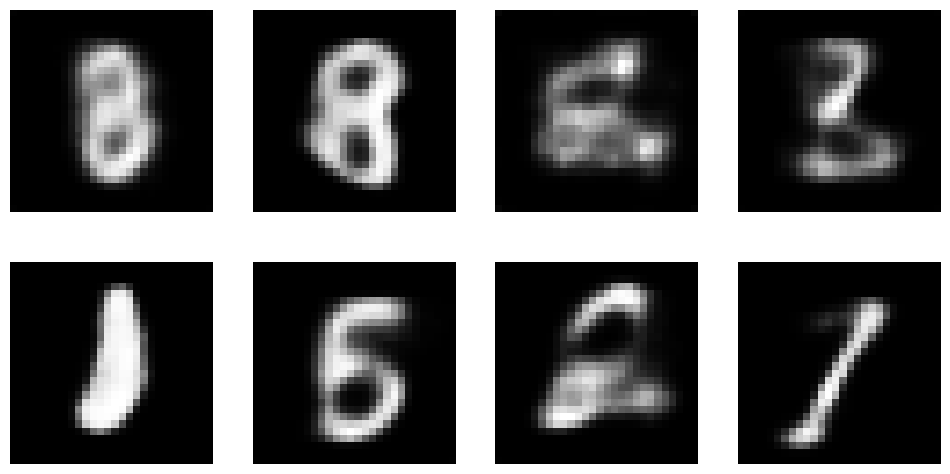

In [ ]:
z = torch.randn(8, 20).to(mi.def_device) # 8 random 20-dimensional inputs
mi.show_images(model.decode(z))

Masterpieces each and every one :)

# Logging Images

Wouldn't it be nice if we could see generated images as training progressed? Here's how we could whip up a quick callback to do that, saving a grid of images to disk every 100 steps:

loss,epoch,train
6883.814,0,train
13442.158,0,eval


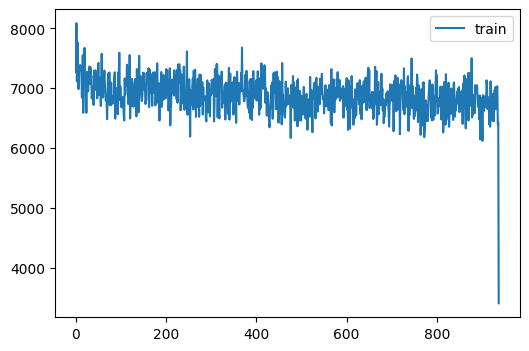

In [ ]:
from torchvision.utils import make_grid
import numpy as np
from PIL import Image

def save_images(preds, save_name):
  """Make a grid of images and save to a file"""
  image_grid = mi.to_cpu(make_grid(preds, nrow=4)).permute(1, 2, 0)
  im_arr = (image_grid.numpy()*255).clip(0, 255).astype(np.uint8)
  im = Image.fromarray(im_arr)
  im.save(save_name)

class LogPreds(mi.Callback):
    def __init__(self, log_every=100):
        self.log_every=log_every
    
    def after_batch(self, learn):
        if learn.iter % self.log_every==0:
            z = torch.randn(8, 20).to(mi.def_device) # 8 random 20-dimensional inputs
            preds = learn.model.decode(z) # Decoded images
            save_images(preds, f'preds_{learn.iter}.jpeg') # Save to file

# Fit another epoch with our new callback
learn.fit(1, cbs=[LogPreds()])

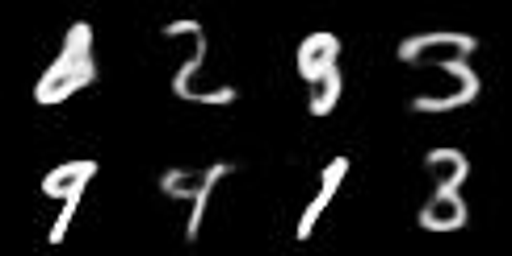

In [ ]:
# View one of the saved images
Image.open('/content/preds_100.jpeg').resize((512, 256))

Using similar code you could save the samples to Weights and Biases, as shown in [this great project by Thomas Capelle](https://wandb.ai/capecape/miniai_ddpm/reports/Next-Frame-Prediction-Using-Diffusion-The-fastai-Approach--VmlldzozMzcyMTYy). 

Another fun option would be to look at ProgressCB, and see if you can plot samples alongside the loss graph.

# Conclusions

And there we go, a fairly quick demo of some of the ways callbacks can be useful to modify and extend the training process without needing to resort to a fully custom training loop and lots of boilerplate. I hope you found this useful :) 